In [31]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import csv
from copy import copy

In [181]:
P = 16

In [144]:
def print_mat(MAT, Format = '%.0f '):
    for r in MAT:
        Line = ''
        for c in r:     
            Line += (Format%(c))  
        print(Line)

In [81]:
def Draw_mat(M, colorbar=False,Figsize = [5,5],title = None,Color=[1,1,1,1]):
    global P
    plt.figure(figsize = Figsize)
    
    for i in np.arange(0.5,P-1,1.0):
        plt.axhline(y=i, xmin=-0.5, xmax=P-0.5, linewidth=2, color=(0.5,0.5,0.5))
        plt.axvline(x=i, ymin=-0.5, ymax=P-0.5, linewidth=2, color=(0.5,0.5,0.5))
    plt.imshow(M if colorbar else 1-M, cmap = plt.cm.hot, interpolation = 'nearest')
    
    plt.xticks(range(0,M.shape[1],4),color=Color)
    plt.yticks(range(0,M.shape[0],4),color=Color)
    plt.tick_params(axis='x', colors=Color)
    plt.tick_params(axis='y', colors=Color)
    
    if title:
        plt.title(title,color=Color)
    
    if colorbar:
        plt.colorbar(ticks=range((int)(np.max(M))+1), orientation='vertical')
    
    plt.show()
                

In [82]:
# Adjacency Matrix
def Get_ADJ(file_path):
    F = pd.read_csv(file_path, delimiter = ' ', header = None)
    return (F.values).astype('float32')

In [83]:
def Get_Static_Table(file_path):
    F = open(file_path,'r')
    FC = csv.reader(F)
    Table = {}
    
    for line in FC:
        l,r = line[0].split('|')
        seq = []
        for ele in line[2:]:
            seq.append((int)(ele))
            
        Table[((int)(l),(int)(r))] = seq
    
    F.close()
    
    return Table

In [222]:
Target_Topology = '16k3grid'

In [223]:
Adj = Get_ADJ('topology/%s.adj'%Target_Topology)
SRTable = Get_Static_Table('topology/%s_Static.srt'%Target_Topology)

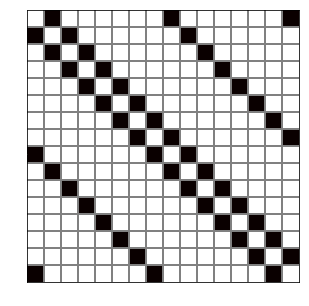

In [219]:
Draw_mat(Adj)

In [187]:
I_P = np.identity(P)

In [188]:
def smoothstep(x):
    R,C = x.shape
    for r in range(R):
        for c in range(C):
            if x[c][r] > 1:
                x[c][r] = 1

In [189]:
def Generate_RouteTree(A_now, D_now):
    global I_P
    D_next = np.matmul(I_P+Adj,D_now)
    smoothstep(D_next)
    return A_now, D_next

In [190]:
from copy import copy

In [191]:
A = copy(Adj)
step = 0
D = np.identity(P)
Routines = []
DIST_M = np.zeros([P,P],dtype='int16')
while (np.min(D) == 0):
    A,D_N = Generate_RouteTree(A,D)
    Routines.append(np.transpose(D_N - D))
    step += 1
    DIST_M += step*(D_N - D).astype('int16')
    D = D_N
    

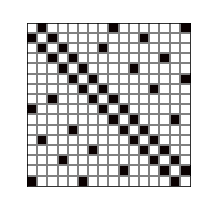

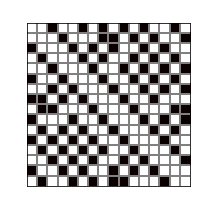

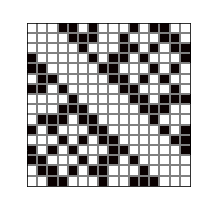

In [192]:
s = 1

for M in Routines:
    Draw_mat(M,Figsize=[3,3],title='<dist = %i>'%s)
    s += 1

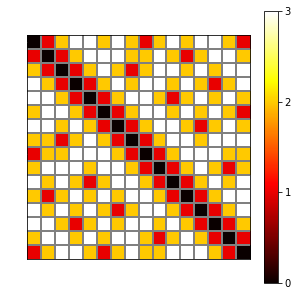

In [193]:
Draw_mat(DIST_M,colorbar=True,Figsize=[5,5],title='distance matrix')

# Find Routine

In [194]:
def get_BAMMA(filepath, rank_map = None):
    global P
    if rank_map == None:
        rank_map = {i:i for i in range(P)}
    
    Algorithm = {}
    F = open(filepath,'r')
    FC = csv.reader(F)
    for line in FC:
        if line[0][0] == '@':         # @ node
            rank = rank_map[(int)(line[0][1:])]
            Algorithm[rank] = []   # add node
            i = 1
            while i < len(line):
                if line[i] == 'C': # Compute
                    Vol = (int)(line[i+1])*\
                          (int)(line[i+2])*\
                          (int)(line[i+3])
                    Algorithm[rank].append(('C',Vol))
                    i += 3
                elif line[i] == 'S': # Compute
                    Area = (int)(line[i+2])*(int)(line[i+3])
                    Algorithm[rank].append(('S',rank_map[(int)(line[i+1])],Area))
                    i += 3
                elif line[i] == 'R': # Compute
                    Area = (int)(line[i+2])*(int)(line[i+3])
                    Algorithm[rank].append(('R',rank_map[(int)(line[i+1])],Area))
                    i += 3
                    
                    
                i += 1
    F.close()            
    return Algorithm
                

# Get Routine Table

In [195]:
rand_series = np.random.permutation(np.arange(P))
random_map = {i:rand_series[i] for i in range(P)}

In [196]:
random_map

{0: 4,
 1: 10,
 2: 5,
 3: 9,
 4: 11,
 5: 0,
 6: 2,
 7: 1,
 8: 3,
 9: 7,
 10: 14,
 11: 12,
 12: 6,
 13: 8,
 14: 13,
 15: 15}

In [197]:
random_map = {
    0:0,
    1:1,
    2:2,
    3:3,
    4:7,
    5:6,
    6:5,
    7:4,
    8:8,
    9:9,
    10:10,
    11:11,
    12:15,
    13:14,
    14:13,
    15:12,
}

# Optimize Map

In [198]:
def Extract_cycles(filepath, rank_map = None):
    global P
    
    if rank_map == None:
        rank_map = {i:i for i in range(P)}
        
    Ideal = np.zeros([P,P],dtype='int16')
    F = open(filepath,'r')
    FC = csv.reader(F)
    for line in FC:
        At = rank_map[(int)(line[0][1:])]
        ind = 1
        for ele in line[1:]:
            if ele == 'S':
                Ideal[At][rank_map[(int)(line[ind+1])]] += 1
                Ideal[rank_map[(int)(line[ind+1])]][At] += 1
            ind += 1
            
    return Ideal

In [202]:
Unmap_Routine = Extract_cycles('BAMMA/P16_Fox441.csv')

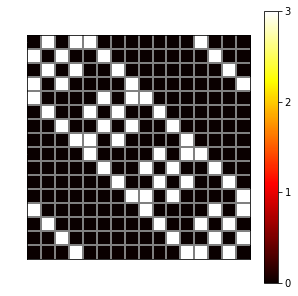

In [203]:
Draw_mat(Unmap_Routine,colorbar=True)

In [238]:
def Get_Loss(Res_M, Alg_M):
    Loss_M = Res_M * (Alg_M>0).astype('int16')
    return np.max(Loss_M), np.mean(Loss_M**5)

In [205]:
def switch_nodes(M,_Map = None):
    if not _Map:
        _Map = {i:i for i in range(M.shape[0])}
    Res = copy(M)
    for src,to in _Map.items():
        Res[to,:] = M[src,:]
    Res1 = copy(Res)
    for src,to in _Map.items():
        Res1[:,to] = Res[:,src]
    return Res1

In [206]:
min_D,min_MD,min_Map = (np.inf,np.inf,None)
max_D,max_MD,max_Map = (0,0,None)
for i in range(5000):
    rand_series = np.random.permutation(np.arange(P))
    random_map = {i:rand_series[i] for i in range(P)}
    Diam,mean_d = Get_Loss(DIST_M, switch_nodes(Unmap_Routine,random_map))
    if mean_d < min_MD:
        min_D = Diam
        min_MD = mean_d
        min_Map = random_map
    if mean_d > max_MD:
        max_D = Diam
        max_MD = mean_d
        max_Map = random_map
print(min_D,min_MD)
print(max_D,max_MD)

3 0.4296875
3 0.65625


In [207]:
Get_Loss(DIST_M, switch_nodes(Unmap_Routine,min_Map))

(3, 0.4296875)

In [26]:
def Get_Exchange(Map):
    E_M = np.zeros([len(Map),len(Map)])
    for i in range(len(Map)):
        E_M[i][Map[i]] = 1
        E_M[Map[i]][i] = 1
    return E_M

In [27]:
def get_OptMap(Topo_M,Alg_M):
    P_ = Topo_M.shape[0]
    E = np.identity(P_)
    
    eigval_T,eigvec_T = np.linalg.eig(Topo_M)
    eigval_A,eigvec_A = np.linalg.eig(Alg_M)
    
    weight_T = np.sqrt(np.abs(eigval_T))*np.transpose(eigvec_T)
    weight_A = np.sqrt(np.abs(eigval_A))*np.transpose(eigvec_A)
    
    DDM = np.zeros([P_,P_])
    for i in range(P_):
        for j in range(P_):
            DDM[i,j] = np.linalg.norm(weight_T[:,i]-weight_A[:,j])
            
    
    Map = {i:i for i in range(P_)}
    Loss = 1
    return Map,Loss

In [173]:
Alg_Name = 'Fox441'
Routine = get_BAMMA('BAMMA/P32_Fox481.csv',rank_map=max_Map)

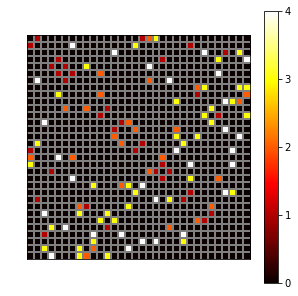

In [167]:
Draw_mat((switch_nodes(Unmap_Routine,min_Map)>0).astype('int16')*DIST_M,colorbar=True)

# static routine

In [65]:
def Route_On_Static(Sender,Reciever,RTable,status,area):
    Act_to_Add = {p:[] for p in range(len(status))}
    Route = RTable[(Sender,Reciever)]
    
    # Sequencial
    prev = Sender
    for p in Route:
        # Waiting Time
        # update status
        if status[p] > status[prev]:
            Act_to_Add[prev].append(('W',status[p]-status[prev]))
            status[prev] = status[p]
        elif status[p] < status[prev]:
            Act_to_Add[p].append(('W',status[prev]-status[p]))
            status[p] = status[prev]
        
        # Comm Time
        Act_to_Add[prev].append(('S',area))
        Act_to_Add[p].append(('R',area))
        status[p] += area
        status[prev] += area
        
        # next pair
        prev = copy(p)

    return Act_to_Add

# dynamic routine

In [66]:
# Recursive Method
def iter_path(From, To, Adj_M, status, path, time):
    Path = copy(path)
    Time = copy(time)
    
    # Get Dest Directly
    if Adj_M[From][To] == 1:
        Path.append(To)
        return Path,abs(status[To]-status[From])
    
    # Compare the results
    my_min_path = []
    min_Time = np.inf
    min_Len = np.inf
    ind = 0
    for p in Adj_M[:,From]:
        if p == 1 and ind not in Path:
            Path.append(ind)
            Time += abs(status[ind]-status[From])
            sub_Path,Time = iter_path(ind,To,Adj_M,status,Path,Time)
            
            if len(sub_Path):
                if len(sub_Path) < min_Len or \
                  (len(sub_Path) == min_Len and Time < min_Time):
                    my_min_path = sub_Path
                    min_Len = len(sub_Path)
                    min_Time = Time
            
        ind += 1
    
    return my_min_path,Time

In [67]:
def Route_On_Dynamic(Sender,Reciever,Adj_M,status,area):
    Act_to_Add = {p:[] for p in range(len(status))}
    Route,Time = iter_path(Sender,Reciever,Adj_M,status,[Sender],0)
    
    # Sequencial
    prev = Sender
    for p in Route:
        # Waiting Time
        # update status
        if status[p] > status[prev]:
            Act_to_Add[prev].append(('W',status[p]-status[prev]))
            status[prev] = status[p]
        elif status[p] < status[prev]:
            Act_to_Add[p].append(('W',status[prev]-status[p]))
            status[p] = status[prev]
        
        # Comm Time
        Act_to_Add[prev].append(('S',area))
        Act_to_Add[p].append(('R',area))
        status[p] += area
        status[prev] += area
        
        # next pair
        prev = copy(p)

    return Act_to_Add
    

In [68]:
def Real_Routine(Raw_Route,Adj_M,method='S'):
    # get num of actions vs each node
    Total_P = len(Raw_Route)

    lengths = np.zeros(Total_P,dtype='int32')

    for r,line in Raw_Route.items():
        lengths[r] = len(line)

    # Result
    Routine = {i:[] for i in range(Total_P)}
    # Nodes Status
    # 0:idle >0:length of queue
    Status = np.zeros(Total_P,dtype='int64')
    
        
    # BFS
    p = 0
    process = np.zeros(Total_P,dtype='int32')
    while True:
        # Finished
        if np.max(np.abs(lengths-process)) == 0:
            return Routine
        # finished nodes
        if lengths[p] == process[p]:
            p = (p+1)%Total_P
            continue
        
        Action = Raw_Route[p][process[p]]
        
        # overhead
        global SRTable
        Status -= np.min(Status)  # processing

        if Action[0] == 'C':      # Computation
            Routine[p].append(Action)
            # add queue
            Status[p] += Action[-1]
        elif Action[0] == 'S':    # Send
            # Route_On_Dynamic
            if method == 'S' or method == 's':
                Acts = Route_On_Static(p,Action[1],SRTable,Status,Action[-1])
            elif method == 'D' or method == 'd':
                Acts = Route_On_Dynamic(p,Action[1],Adj_M,Status,Action[-1])
            else:
                print('Unrecognized Method: ',method)
                return
            
            for pp,act in Acts.items():
                Routine[pp] += act
            
        elif Action[0] == 'R':    # Recieve
            pass # done by sender
            
        
        
        # Update
        process[p] += 1
        p = (p+1)%Total_P
        
        
        
    return Routine

In [69]:
# map_rank
def swap_row(M,r1,r2):
    temp_r = M[r2,:]
    M[r2,:] = M[r1,:]
    M[r1,:] = temp_r
    
def swap_col(M,c1,c2):
    temp_c = M[:,c2]
    M[:,c2] = M[:,c1]
    M[:,c1] = temp_c

def map_ranks(Adj_M,Map):
    new_Adj = copy(Adj_M)
    for f,t in Map.items:
        swap_row(new_Adj,f,t)
        swap_col(new_Adj,f,t)
        

# Draw squares

In [70]:
from matplotlib import patches

In [71]:
Color_Table = {
    'C':[0,1,0,1],
    'S':[1,0,0,1],
    'R':[1,1,0,1],
    'W':[0.3,0.3,0.3]
}

In [72]:
def Draw_Route_Table(Routes,title=None):
    global Color_Table
    Total_P = len(Routes)
    Fig1 = plt.figure(figsize=[10,10])
    ax = plt.subplot(111)
    # comp:green | send:red | recv:orange | idle:gray
    x_max = 0
    distribution = np.zeros(Total_P,dtype='int64')
    for p in range(Total_P):
        x = 0
        m_xmax = 0
        for act in Routes[p]:
            ax.add_patch(
                patches.Rectangle((x,p-0.24),act[1],0.48,
                                  fill=True,
                                  ec=None,
                                  fc=Color_Table[act[0]])
            )
            x += act[1]
            m_xmax += act[1]
        if m_xmax > x_max:
            x_max = m_xmax
            
        distribution[p] = m_xmax
            
    XTicks = np.array(np.arange(0,(int)(x_max),(int)(x_max/10)))
    if x_max-XTicks[-1] < (int)(x_max/15):
        XTicks[-1] = x_max
    else:
        XTicks = np.append(XTicks,x_max)
    
    plt.xticks(XTicks,color=[1,1,1,1])
    plt.yticks(range(Total_P),color=[1,1,1,1])
    plt.axis([0,x_max,-0.5,Total_P-0.5])
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    
    # legends
    legends = [
        patches.Patch(color='green', label='Computation'),
        patches.Patch(color='red', label='Send'),
        patches.Patch(color='yellow', label='Recieve'),
        patches.Patch(color='gray', label='Idle/Wait')
    ]
    
    plt.legend(handles=legends,
               loc='center left', 
               bbox_to_anchor=(1.02, 0.75))
    if title:
        plt.title(title,color=[1,1,1,1])
        
    plt.savefig('Results/%s.jpg'%(title))

    plt.show()
    return distribution

In [73]:
RR = Real_Routine(Routine,Adj,method='D')
Distribution_D = Draw_Route_Table(RR,title='%s_%s__DYNAMIC'%(Target_Topology,Alg_Name))

KeyboardInterrupt: 

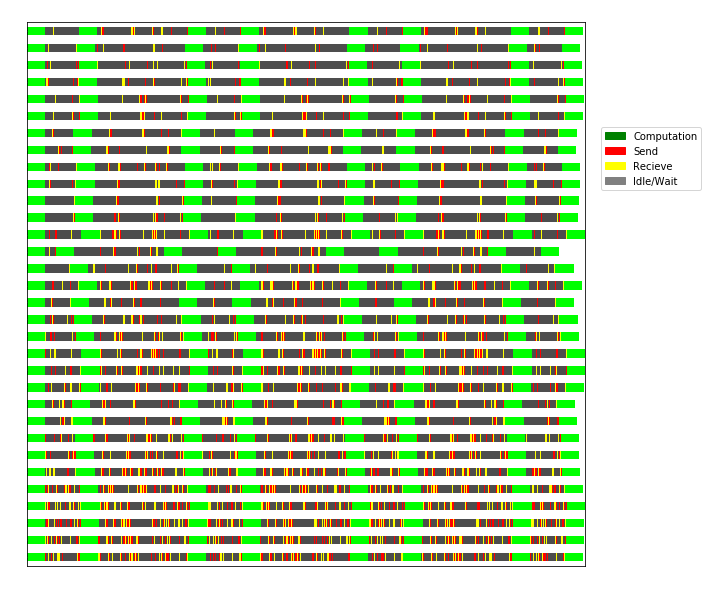

In [174]:
RR = Real_Routine(Routine,Adj,method='S')
Distribution_S = Draw_Route_Table(RR,title='%s_%s__STATIC'%(Target_Topology,Alg_Name))

# Compare Distributions

In [ ]:
def compare_distributions(dis1,dis2,
                          color1=[1,0,0,0.5],
                          color2=[0,0,1,0.5],
                          width = 1):
    Fig = plt.figure(figsize=[10,5])
    Total_P = len(dis1)
    # check the number of nodes resp.
    assert len(dis1)==len(dis2),'distributions not matched!'
    
    # bar chart
    ax = plt.subplot(111)
    for p in range(Total_P):
        ax.add_patch(
            patches.Rectangle((p-width/2,0),width,dis1[p],
                              fill=True,
                              ec=[0.8,0.8,0.8,1],
                              fc=color1)
            )
        ax.add_patch(
            patches.Rectangle((p-width/4,0),width/2,dis2[p],
                              fill=True,
                              ec=[0.8,0.8,0.8,1],
                              fc=color2)
            )
    
    max_D = max([np.max(dis1),np.max(dis2)])
   

    Y_Ticks = list(range(0,max_D,(int)(max_D/10)))
    if max_D-Y_Ticks[-1] < (int)(max_D/15):
        Y_Ticks[-1] = max_D
    
    plt.xticks(range(Total_P))
    plt.yticks(Y_Ticks)
    plt.axis([0-0.5,Total_P-0.5,0,max_D*1.05])
    plt.show()

In [ ]:
compare_distributions(Distribution_D,Distribution_S)

# Distribution upon MD

In [176]:
def get_Longest(Routes):
    Total_P = len(Routes)
    x_max = 0
    for p in range(Total_P):
        m_xmax = 0
        for act in Routes[p]:
            m_xmax += act[1]
        if m_xmax > x_max:
            x_max = m_xmax
    return x_max

In [239]:
pairs = []
TT = 0
for T in range(500):
    rand_series = np.random.permutation(np.arange(P))
    random_map = {i:rand_series[i] for i in range(P)}
    Diam,mean_d = Get_Loss(DIST_M, switch_nodes(Unmap_Routine,random_map))
    
    T_Routine = get_BAMMA('BAMMA/P16_Fox441.csv',rank_map=random_map)
    m_time = get_Longest(Real_Routine(T_Routine,Adj,method='S'))
    
    pairs.append((mean_d,m_time))
    if T > TT + 49:
        print(T)
        TT = T

50
100
150
200
250
300
350
400
450


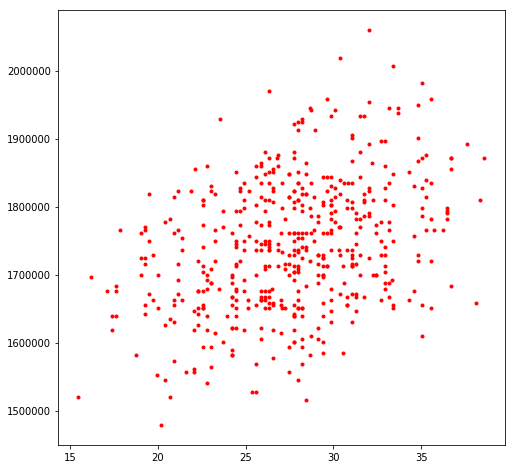

In [240]:
T_Fig = plt.figure(figsize=(8,8))
for p in pairs:
    plt.plot(p[0],p[1],'r.')
    
plt.show()